### 7- Trying to make more accurate model

In [147]:
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [148]:
#from part 1

save_path = 'saved_models/'
os.makedirs(save_path, exist_ok=True)

def load_data(data_path='data/'):
    train = os.path.join(data_path, "train.csv")
    test = os.path.join(data_path, "test.csv")
    return pd.read_csv(train), pd.read_csv(test)

import joblib
def save_model(model, fname="model.pkl"):
    joblib.dump(model, os.path.join(save_path,fname))
def load_model(fname):
    return joblib.load(os.path.join(save_path,fname))

from sklearn.model_selection import cross_val_score
def display_scores(model, X, y, cv=10):
    scores = cross_val_score(model, X, y, n_jobs=-1, scoring='neg_mean_squared_error', cv=cv)
    print(str(model.__class__.__name__) + '; mean_rmse: {:.4f} w std ({:.4f})'.format((np.sqrt(-scores)).mean(), (np.sqrt(-scores)).std()))
    return scores 

def prep_to_submit(ids, test, model):
    prepared = full_pipeline.transform(test)
    preds = model.predict(prepared)
    preds = np.expm1(preds)
    preds_df = pd.DataFrame({'Id': ids, 'SalePrice': preds})
    preds_df.to_csv(model.__class__.__name__ + '_preds.csv', index=False)

In [149]:
train_df, test_df = load_data()

test_ids = test_df['Id'].copy()

train_df.drop('Id', axis=1, inplace=True)
test_df.drop('Id', axis=1, inplace=True)

# train_df.loc[:,'Train'] = 1
# test_df.loc[:,'Train'] = 0
# test_df['SalePrice'] = 0
# df = pd.concat([train,test], ignore_index=True)

/Users/cgokalp/anaconda/envs/ds_lab/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


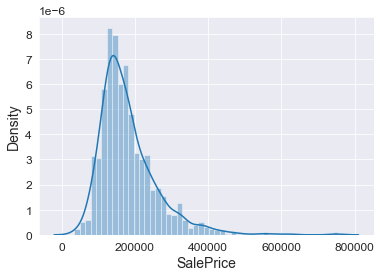

In [150]:
sns.distplot(train_df['SalePrice']);

looks skewed, lets apply log transform to get a more normal looking distribtuion

/Users/cgokalp/anaconda/envs/ds_lab/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


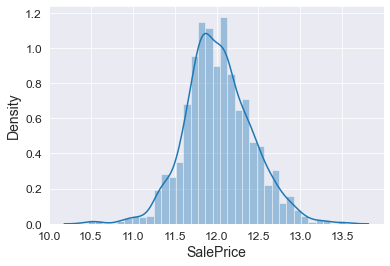

In [151]:
prices = pd.DataFrame({"price":train_df["SalePrice"], "log(price + 1)":np.log1p(train_df["SalePrice"])})
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])
sns.distplot(train_df['SalePrice']);

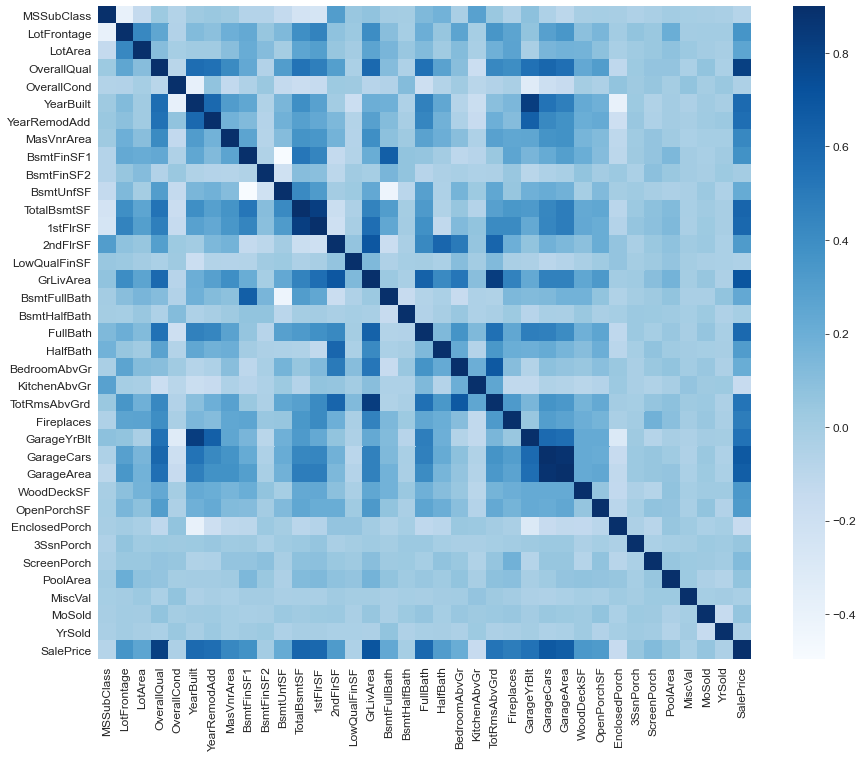

In [152]:
corrmat = train_df.corr()
plt.subplots(figsize=(15,12));
sns.heatmap(corrmat, vmax=0.9, cmap="Blues", square=True);

- looks GarageCars and Garage Area are highly correlated with each other, which is expected.
- looks like TotRmsAbvGrd and GrLivArea are highly correlated

In [153]:
corrmat['SalePrice'].sort_values(ascending=False)[:10]

SalePrice       1.000000
OverallQual     0.817185
GrLivArea       0.700927
GarageCars      0.680625
GarageArea      0.650888
TotalBsmtSF     0.612134
1stFlrSF        0.596981
FullBath        0.594771
YearBuilt       0.586570
YearRemodAdd    0.565608
Name: SalePrice, dtype: float64

Let's investigate highly correlated features

/Users/cgokalp/anaconda/envs/ds_lab/lib/python3.7/site-packages/seaborn/axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


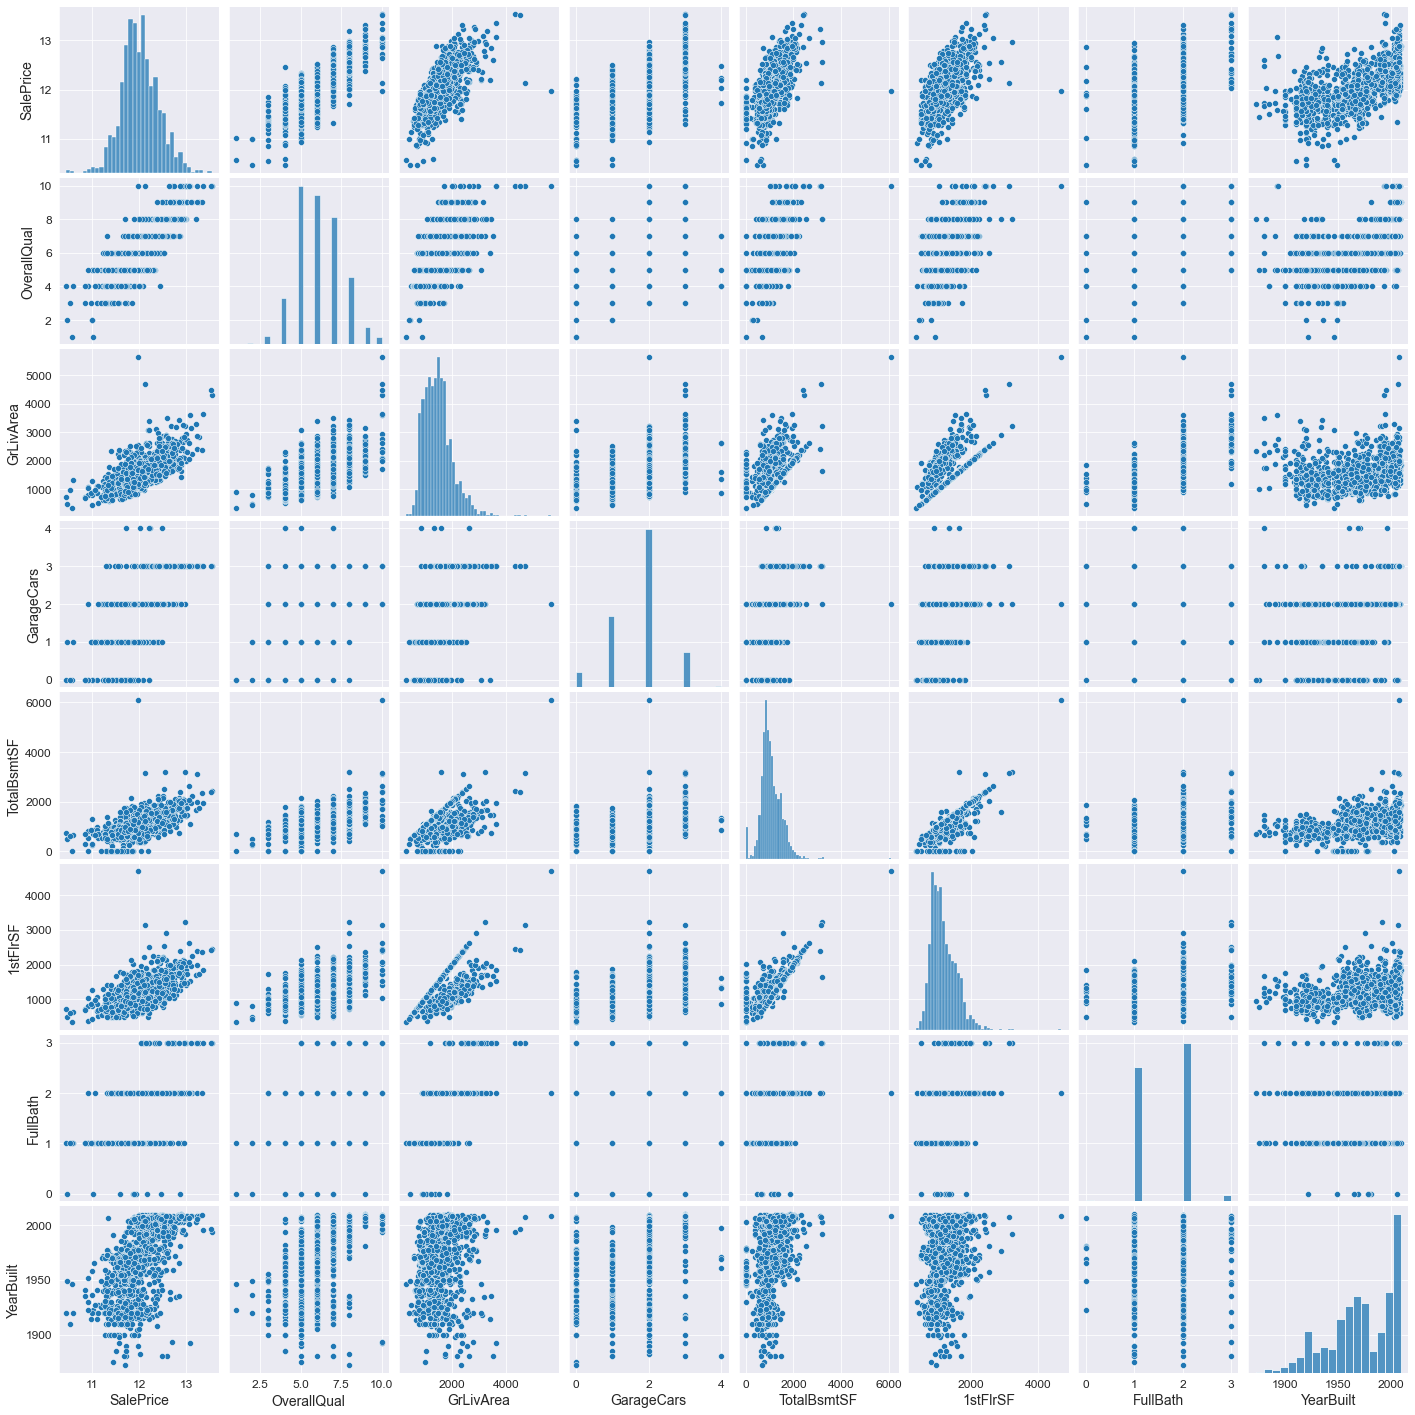

In [154]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt']
sns.pairplot(train_df[cols], size = 2.5)
plt.show();

- There are 2 data points in GrLiveArea vs Sale Price that looks like an outlier
- There is also another data point in TotalBsmtSF vs Sale price taht looks like an outlier

Lets deal with these

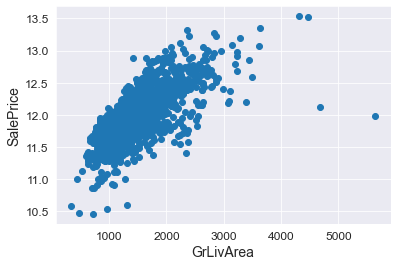

In [155]:
plt.scatter(x = train_df['GrLivArea'], y = train_df['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GrLivArea')
plt.show()

lets drop those 2 examples that looks a lot like outliers

In [156]:
train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<12.5)].index)

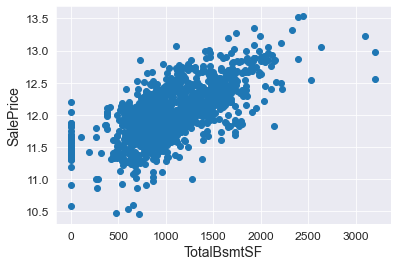

In [157]:
plt.scatter(x = train_df['TotalBsmtSF'], y = train_df['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('TotalBsmtSF')
plt.show()

That data point looked like an outlier to TotalBsmtSF was the same point we just dropped - so we are good

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

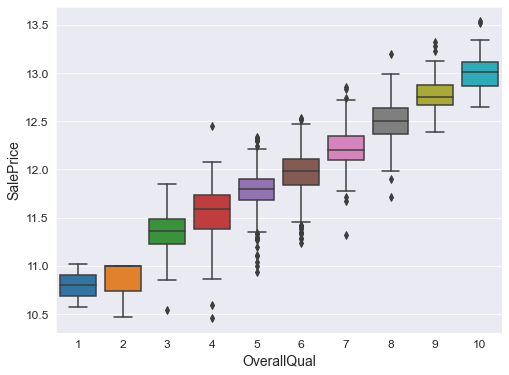

In [158]:
# feature OverallQual
plt.subplots(figsize=(8, 6))
sns.boxplot(x=train_df['OverallQual'], y=train_df["SalePrice"])

Lets treat this as a category rather than a numerical value

In [159]:
train_df['OverallCond'] = train_df['OverallCond'].astype(str)
test_df['OverallCond'] = test_df['OverallCond'].astype(str)

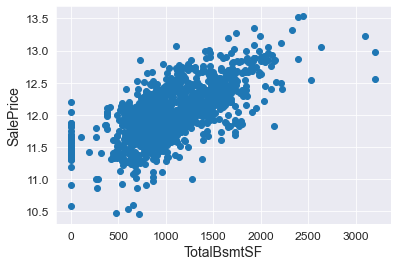

In [160]:
plt.scatter(x = train_df['TotalBsmtSF'], y = train_df['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('TotalBsmtSF')
plt.show()

In [161]:
train_labels = train_df['SalePrice'].copy()

train = train_df.drop('SalePrice', axis=1)
test = test_df.copy()

In [162]:
cat_attribs = train.select_dtypes(include=[np.object]).columns
train[cat_attribs].describe(include='all')

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1458,1458,91,1458,1458,1458,1458,1458,1458,1458,...,1377,1377,1377,1377,1458,6,281,54,1458,1458
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1149,1452,50,925,1311,1457,1051,1380,225,1260,...,869,605,1309,1324,1338,2,157,49,1267,1198


In [163]:
train['Street'].value_counts()

Pave    1452
Grvl       6
Name: Street, dtype: int64

In [164]:
train['Utilities'].value_counts()

AllPub    1457
NoSeWa       1
Name: Utilities, dtype: int64

lets drop the above two categorical features, there is no variation no information here to learn from

In [165]:
train.drop(columns=['Utilities', 'Street'], inplace=True)
test.drop(columns=['Utilities', 'Street'], inplace=True)

In [166]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1452,0.995885
MiscFeature,1404,0.962963
Alley,1367,0.937586
Fence,1177,0.807270
FireplaceQu,690,0.473251
LotFrontage,259,0.177641
GarageType,81,0.055556
GarageCond,81,0.055556
GarageFinish,81,0.055556
GarageQual,81,0.055556


In [167]:
# From the description of data MSSubClass looks like a categorical value
train[['MSSubClass', 'YrSold', 'MoSold']] = train[['MSSubClass', 'YrSold', 'MoSold']].astype(str)
test[['MSSubClass', 'YrSold', 'MoSold']] = test[['MSSubClass', 'YrSold', 'MoSold']].astype(str) 

### Handling missing values

In [168]:
#From: got ideas from https://www.kaggle.com/niteshx2/top-50-beginners-stacking-lgb-xgb

def fix_nas(df):
    #Fill na for these column with standard equipment for those - intuition from data description.txt
    df['Functional'] = df['Functional'].fillna('Typ') 
    df['Electrical'] = df['Electrical'].fillna('SBrkr')
    df['KitchenQual'] = df['KitchenQual'].fillna('TA')
    df['SaleType'] = df['SaleType'].fillna('Other')
    df['Exterior1st'] = df['Exterior1st'].fillna('Other')
    df['Exterior2nd'] = df['Exterior2nd'].fillna('Other')
    
    #None for not exists - intuition from data description.txt
    df['PoolQC'] = df['PoolQC'].fillna('None')
    
    #These two are probably very related
    df['MSZoning'] = df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    #Na means No Garage
    for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
        df[col] = df[col].fillna(0)
    
    #Na means No Garage 
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        df[col] = df[col].fillna('None')
    
    #Na means there's no basement
    for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
        df[col] = df[col].fillna('None')
    
    #Na means no basement, so the measurement is 0
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
        df[col] = df[col].fillna(0)
        
    for col in train.select_dtypes(include=[np.object]).columns:
        df[col] = df[col].fillna('None')
        
    for col in train.select_dtypes(include=[np.number]).columns:
        df[col] = df[col].fillna(0)
    
    return df

In [169]:
train_df = fix_nas(train_df)
test_df = fix_nas(test_df)

### Handle skewness of data

In [170]:
num_attribs = train.select_dtypes([np.number]).columns

skewed_cols = num_attribs[train[num_attribs].skew() > 0.7]
train[skewed_cols] = np.log1p(train[skewed_cols])
test[skewed_cols] = np.log1p(test[skewed_cols])

### Feature Engineering

In [171]:
def combine_features(df):
    
    # Exists or not
    df['HasPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    df['Has2ndfloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    df['HasGarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    df['HasBsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    df['HasFireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    
    #Unfinished or not
    df['BsmtFinType1_Unf'] = 1*(df['BsmtFinType1'] == 'Unf')
    
    df['OldHouse'] = df['YearBuilt'].apply(lambda x: 1 if x <1990 else 0)
    
    #Some aggregated features
    df['TotalSF']=df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['TotalBathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) +
                            df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))
    df['TotalPorchSF'] = (df['OpenPorchSF'] + df['3SsnPorch'] +
                          df['EnclosedPorch'] + df['ScreenPorch'] +
                          df['WoodDeckSF'])
    
    
  
    df['Age_YrBuilt'] = df['YrSold'] - df['YearBuilt']
    df['Age_YrRemod'] = df['YrSold'] - df['YearRemodAdd']
    df['Age_Garage'] = df['YrSold'] - df['GarageYrBlt']
    df['Remodeled'] = df['YearBuilt']!=df['YearRemodAdd']

    #to fix if the garageyrbuilt is 0 for example - its 0 if garage was never built
    df['Age_YrBuilt'] = df['Age_YrBuilt'].apply(lambda x: 0 if x <0 else x)
    df['Age_YrRemod'] = df['Age_YrRemod'].apply(lambda x: 0 if x <0 else x)
    df['Age_Garage'] = df['Age_Garage'].apply(lambda x: 0 if x <0 else x)
        
    
    return df

In [172]:
train_df = combine_features(train_df)
test_df = combine_features(test_df)

In [173]:
corrmat = train_df.corr()
corrmat['SalePrice'].sort_values(ascending=False)[:25]

SalePrice         1.000000
TotalSF           0.825326
OverallQual       0.821405
GrLivArea         0.725211
GarageCars        0.681033
TotalBathrooms    0.676678
GarageArea        0.656129
TotalBsmtSF       0.647563
1stFlrSF          0.620500
FullBath          0.595899
YearBuilt         0.587043
YearRemodAdd      0.565992
TotRmsAbvGrd      0.537702
HasFireplace      0.510253
Fireplaces        0.491998
MasVnrArea        0.430570
TotalPorchSF      0.399695
BsmtFinSF1        0.392283
GarageYrBlt       0.349013
WoodDeckSF        0.334251
OpenPorchSF       0.325215
HasGarage         0.322994
2ndFlrSF          0.319953
HalfBath          0.314186
LotArea           0.260544
Name: SalePrice, dtype: float64

In [174]:
corrmat['SalePrice'].sort_values(ascending=True)[:25]

OldHouse           -0.595325
Age_YrBuilt        -0.587767
Age_YrRemod        -0.568529
Age_Garage         -0.349109
EnclosedPorch      -0.149029
KitchenAbvGr       -0.147534
BsmtFinType1_Unf   -0.097133
Remodeled          -0.074066
MSSubClass         -0.073969
LowQualFinSF       -0.037951
YrSold             -0.037151
MiscVal            -0.020012
BsmtHalfBath       -0.005124
BsmtFinSF2          0.004863
3SsnPorch           0.054914
MoSold              0.057064
PoolArea            0.074338
HasPool             0.076516
ScreenPorch         0.121245
Has2ndfloor         0.150568
LotFrontage         0.183182
HasBsmt             0.199626
BedroomAbvGr        0.209035
BsmtUnfSF           0.221892
BsmtFullBath        0.237099
Name: SalePrice, dtype: float64

In [175]:
#Lets drop the two least correlated features
train.drop(columns=['BsmtFinSF2', 'BsmtHalfBath'], inplace=True)
test.drop(columns=['BsmtFinSF2', 'BsmtHalfBath'], inplace=True)

In [176]:
#### Type of features
num_attribs = train.select_dtypes([np.number]).columns

ord_attribs = list(['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'GarageFinish', 'LandSlope', 'YrSold', 'MoSold'])

cat_attribs = train.select_dtypes(include=[np.object]).columns

print('numerical:{} \n\n categorical:{}'.format(num_attribs, cat_attribs))

numerical:Index(['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal'],
      dtype='object') 

 categorical:Index(['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallCond', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional'

### Prep data for models

In [192]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="mean")),
        ('std_scaler', RobustScaler()),
    ])

# ord_pipeline = Pipeline([
#         ("imputer", SimpleImputer(strategy="most_frequent")),
#         ("encoder", OrdinalEncoder()),
#     ])

cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown='ignore',sparse=False)),
    ])


In [193]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold

full_pipeline = ColumnTransformer([
#         ("ord", ord_pipeline, ord_attribs),
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

In [194]:
train_prepared = full_pipeline.fit_transform(train)

In [195]:
train_prepared.shape

(1458, 318)

### Model selection

In [34]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

ridge_reg = Ridge(max_iter=3000)
lasso_reg = Lasso(max_iter=3000)

param_grid = [{'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]}]

ridge_grid = GridSearchCV(ridge_reg, param_grid, cv=10, scoring='neg_mean_squared_error', return_train_score=True)
lasso_grid = GridSearchCV(lasso_reg, param_grid, cv=10, scoring='neg_mean_squared_error', return_train_score=True)

ridge_grid.fit(train_prepared, train_labels)
lasso_grid.fit(train_prepared, train_labels)

GridSearchCV(cv=10, estimator=Lasso(max_iter=3000),
             param_grid=[{'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05,
                                    0.1, 0.5, 1, 5, 10, 50]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [35]:
lasso_scores = display_scores(lasso_grid.best_estimator_, train_prepared, train_labels)
ridge_scores = display_scores(ridge_grid.best_estimator_, train_prepared, train_labels)

Lasso; mean_rmse: 0.1092 w std (0.0144)
Ridge; mean_rmse: 0.1104 w std (0.0134)


In [36]:
# lasso_res = lasso_grid.cv_results_

# for mean_score, params in zip(lasso_res["mean_test_score"], lasso_res["params"]):
#     print(np.sqrt(-mean_score), params)

In [37]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

gbrt = GradientBoostingRegressor(min_samples_leaf=6, max_depth=4, max_features='sqrt', subsample=0.8, warm_start=True)
X_train, X_val, y_train, y_val = train_test_split(train_prepared, train_labels)

min_val_error = np.inf
err_up = 0
for n_estimators in range(1,1000):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        err_up = 0
    else:
        err_up += 1
        if err_up == 5:
            break

## Found the values by cheking cross val scores with the below cell - couldnt run grid search as I had to do the loop for early stopping
## so ended up doing the grid search manually for good parameters

In [38]:
gbrt_scores = display_scores(gbrt, train_prepared, train_labels)

GradientBoostingRegressor; mean_rmse: 0.1177 w std (0.0183)


In [39]:
from sklearn.svm import SVR

param_grid = [
#         {'kernel': ['linear'], 'C': [0.1, 1, 10, 20]},
        {'kernel': ['rbf'], 'C': [0.01, 1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0], 'gamma': [1e-6, 0.00001, 0.0003, 0.0001, 0.003, 0.01, 0.03, 0.1]},
    ]

svm_reg = SVR()
svm_grid = GridSearchCV(svm_reg, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
svm_grid.fit(train_prepared, train_labels)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  1.1min finished


GridSearchCV(cv=10, estimator=SVR(), n_jobs=-1,
             param_grid=[{'C': [0.01, 1.0, 3.0, 10.0, 30.0, 100.0, 300.0,
                                1000.0, 3000.0],
                          'gamma': [1e-06, 1e-05, 0.0003, 0.0001, 0.003, 0.01,
                                    0.03, 0.1],
                          'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)

In [40]:
svm_scores = display_scores(svm_grid.best_estimator_, train_prepared, train_labels, cv=10)

SVR; mean_rmse: 0.1131 w std (0.0123)


In [41]:
svm_grid.best_params_

{'C': 30.0, 'gamma': 0.0003, 'kernel': 'rbf'}

In [42]:
# svm_grid_results = svm_grid.cv_results_
# for mean_score, params in zip(svm_grid_results["mean_test_score"], svm_grid_results["params"]):
#     print(np.sqrt(-mean_score), params)

In [43]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {
        'n_estimators': [50, 100, 250, 500, 1000],
        'max_features': [32, 64, 128],
        'max_depth': [2, 4, 8, 16, 32],
        'bootstrap': [False, True],
#         'max_samples': [0.25, 0.5, 0.75],
        'min_samples_leaf': [2, 3, 5, 8],
        'min_samples_split' : [2, 4, 8]
    }



rf_reg = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(rf_reg, param_grid=param_grid, cv=4,
                       scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)


rf_grid.fit(train_prepared, train_labels)

Fitting 4 folds for each of 1800 candidates, totalling 7200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 170 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 373 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1021 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1466 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1993 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 2600 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 3289 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done 4058 tasks      | elapsed: 29.5min
[Parallel(n_jobs=-1)]: Done 4909 tasks      | elapsed: 32.7min
[Parallel(n_jobs=-1)]: Done 5840 tasks      | elapsed: 37.6min
[Parallel(n_jobs=-1)]: Done 6853 tasks      | elapsed: 43.5min
[Parallel(n_jobs=-1)]: Done 7200 out of 7200 | elapsed: 46.1min finished


GridSearchCV(cv=4, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [False, True],
                         'max_depth': [2, 4, 8, 16, 32],
                         'max_features': [32, 64, 128],
                         'min_samples_leaf': [2, 3, 5, 8],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [50, 100, 250, 500, 1000]},
             scoring='neg_mean_squared_error', verbose=2)

In [44]:
rf_grid.best_params_

{'bootstrap': False,
 'max_depth': 16,
 'max_features': 128,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 500}

In [45]:
rf_scores = display_scores(rf_grid.best_estimator_, train_prepared, train_labels, cv=10)

RandomForestRegressor; mean_rmse: 0.1296 w std (0.0147)


In [46]:
# rf_grid_results = rf_grid.cv_results_
# for mean_score, params in zip(rf_grid_results["mean_test_score"], rf_grid_results["params"]):
#     print(np.sqrt(-mean_score), params)

In [47]:
import xgboost

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
param_distribs = {
        'max_depth': randint(low=3, high=20),
        'eta': [0.01, 0.05, 0.1],
        'subsample' : [0.8, 1],
        'colsample_bytree' : [0.3, 0.5, 0.8],
        'n_estimators' : randint(low=400, high=1000),
        'min_child_weight' : np.arange(1,6,2)
    }

xgb_reg = xgboost.XGBRegressor(silent=True, early_stopping_rounds=5)

xgb_grid = RandomizedSearchCV(xgb_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, n_jobs=-1, scoring='neg_mean_squared_error', random_state=42)
xgb_grid.fit(train_prepared, train_labels);

[16:22:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { early_stopping_rounds, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [48]:
xgb_scores = display_scores(xgb_grid.best_estimator_, train_prepared, train_labels, cv=5)

XGBRegressor; mean_rmse: 0.1147 w std (0.0068)


In [49]:
xgb_grid.best_params_

{'colsample_bytree': 0.3,
 'eta': 0.05,
 'max_depth': 3,
 'min_child_weight': 5,
 'n_estimators': 880,
 'subsample': 0.8}

In [66]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

xgb_final = xgboost.XGBRegressor(early_stopping=7)

estimators = [('r', ridge_grid.best_estimator_),
              ('l', lasso_grid.best_estimator_),
              ('boost', gbrt),
              ('svm', svm_grid.best_estimator_),
              ('rf', rf_grid.best_estimator_),
              ('xgb', xgb_grid.best_estimator_)
             ]

stack = StackingRegressor(estimators=estimators, n_jobs=-1, passthrough=True)
stack_2 = StackingRegressor(estimators=estimators, n_jobs=-1, passthrough=False)

In [67]:
display_scores(stack, train_prepared, train_labels)

StackingRegressor; mean_rmse: 0.1126 w std (0.0144)


array([-0.01265902, -0.01047889, -0.01145014, -0.01530807, -0.02073417,
       -0.00988748, -0.0119265 , -0.00881585, -0.01115277, -0.01646357])

In [68]:
stack_scores = display_scores(stack_2, train_prepared, train_labels)

StackingRegressor; mean_rmse: 0.1069 w std (0.0151)


In [88]:
stack_2.fit(train_prepared, train_labels);

In [143]:
def blended_predictions(X):
    return ((0.1 * ridge_grid.best_estimator_.predict(X)) + \
            (0.2 * lasso_grid.best_estimator_.predict(X)) + \
            (0.1 * gbrt.predict(X)) + \
            (0.1 * xgb_grid.best_estimator_.predict(X)) + \
            (0.1 * svm_grid.best_estimator_.predict(X)) + \
            (0.05 * rf_grid.best_estimator_.predict(X)) + \
            (0.35 * stack_2.predict(X)))

In [144]:
blended_mse = mean_squared_error(train_labels, blended_predictions(train_prepared))
blended_score = np.sqrt(blended_mse)
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.07070958017334458


In [138]:
model = stack_2

In [145]:
model.fit(train_prepared, train_labels)
prepared = full_pipeline.transform(test)

# preds = model.predict(prepared)
preds = blended_predictions(prepared)
preds_transformed = np.expm1(preds)
preds_df = pd.DataFrame({'Id': test_ids, 'SalePrice': preds_transformed})
preds_df.to_csv('submission_' + model.__class__.__name__ + '.csv', index=False)

In [146]:
from sklearn.metrics import mean_squared_error

model.fit(train_prepared, train_labels)
# train_preds = model.predict(train_prepared)
train_preds = blended_predictions(train_prepared)
mse = mean_squared_error(train_labels, train_preds)
rmse = np.sqrt(mse)
rmse

0.07173277333845891

In [72]:
### https://www.kaggle.com/orhankaramancode/ensemble-stacked-regressors-92-acc
# scores = [lasso_scores, ridge_scores, svm_scores, gbrt_scores, rf_scores, xgb_scores, stack_scores]
# scores = [list(score) for score in scores]
# model_names = ['Lasso', 'Ridge', 'SVM', 'GRBT', 'XGB', 'RF', 'STACK']
# score_medians = ([round(np.median([mean for mean in modelscore]),5) for modelscore in scores])

# sns.set_style("darkgrid")
# params = {
#          'axes.labelsize': 30,
#          'xtick.labelsize':20,
#          'ytick.labelsize':18
# }
# plt.rcParams.update(params)

# fig, ax = plt.subplots(figsize=(14,8))

# vertical_offset = 0.001

# ax.set_title('Learning Model Score Comparison')
# bp = sns.boxplot(x=model_names, y=scores, ax=ax)


# for xtick in bp.get_xticks():
#     bp.text(xtick,score_medians[xtick] - vertical_offset,score_medians[xtick], 
#             horizontalalignment='center',size=18, color='w',weight='semibold')
    
# plt.show()

### Save models

In [73]:
models = [ridge_grid, lasso_grid, xgb_grid, svm_grid, gbrt, rf_grid, stack]
for model in models:
    save_model(model, fname=model.__class__.__name__ + '.pkl')

In [ ]:
# sns.set_style("darkgrid")
# params = {
#          'axes.labelsize': 32,
#          'xtick.labelsize':22,
#          'ytick.labelsize':24
# }
# plt.rcParams.update(params)

# features_to_viz = ['Neighborhood','BsmtQual','ExterQual','FireplaceQu','ExterCond',
#                    'KitchenQual','LotShape','OverallQual', 'FullBath','HalfBath',
#                    'TotRmsAbvGrd','Fireplaces','KitchenAbvGr']

# # Because there are a lot of variables to vizualize, 
# # sorting them helps me keep track of which var is where
# features_to_viz = sorted(features_to_viz)


# ncols = 2
# nrows = math.ceil(len(features_to_viz)/ncols)
# unused = (nrows*ncols) - len(features_to_viz)


# figw, figh= ncols*18, nrows*12

# fig, ax = plt.subplots(nrows,ncols, figsize=(figw,figh))
# fig.subplots_adjust(hspace=0.2,wspace=0.2)
# ax = ax.flatten()
# for i in range(unused,0,-1):
#     fig.delaxes(ax[-i])



# for n, col in enumerate(features_to_viz):
#     ordering = stacked_DF.loc[stacked_DF['Train']==1].groupby(by=col)['SalePrice'].median().sort_values().index
#     sns.boxplot(x='SalePrice',y=col, data=stacked_DF.loc[stacked_DF['Train']==1], order=ordering, ax=ax[n], orient='h')


# plt.show()